In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
 !pip install ir_datasets

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.0/859.0 kB 13.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.8 MB/s eta 0:00:0000:01
  Created wheel for warc3-wet-clueweb09: filename=warc3_wet_clueweb09-0.2.5-py3-none-any.whl size=18920 sha256=bca838bc26bc216fe87924c8efd55076555a06860d0da4c466e180620f92964c
  Stored in directory: /root/.cache/pip/wheels/63/f9/dc/2dd16d3330e327236e4d407941975c42d5159d200cdb7922d8
  Created wheel for cbor: filename=cbor-1.0.0-cp311-cp311-linux_x86_64.whl size=53931 sha256=8f13d54af67cada62d3ab58956f428d873eb6e823a04cb15f74814364324a540
  Stored in directory: /root/.cache/pip/wheels/21/6b/45/0c34253b1af07d1d9dc524f6d44d74a6b191c43152e6aaf641
Successfully built warc3-wet-clueweb09 c

In [3]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 75.9 MB/s eta 0:00:00:00:01:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy

# Cranfield Dataset

In [5]:
import ir_datasets
dataset = ir_datasets.load("cranfield")

In [6]:
# Access and print a few documents
for doc in dataset.docs_iter():
    print("Document ID:", doc.doc_id)
    print("Text:", doc.text)
    break 
print("\n")

# Access and print a few queries
for query in dataset.queries_iter():
    print("Query ID:", query.query_id)
    print("Text:", query.text)
    break
print("\n")

# Access and print relevance judgments
for qrel in dataset.qrels_iter():
    print("Query ID:", qrel.query_id)
    print("Relevant Doc ID:", qrel.doc_id)
    print("Relevance Score:", qrel.relevance)
    break


[INFO] [starting] http://ir.dcs.gla.ac.uk/resources/test_collections/cran/cran.tar.gz
[INFO] [finished] http://ir.dcs.gla.ac.uk/resources/test_collections/cran/cran.tar.gz: [00:00] [507kB] [1.04MB/s]


Document ID: 1
Text: experimental investigation of the aerodynamics of a
wing in a slipstream .
  an experimental study of a wing in a propeller slipstream was
made in order to determine the spanwise distribution of the lift
increase due to slipstream at different angles of attack of the wing
and at different free stream to slipstream velocity ratios .  the
results were intended in part as an evaluation basis for different
theoretical treatments of this problem .
  the comparative span loading curves, together with
supporting evidence, showed that a substantial part of the lift increment
produced by the slipstream was due to a /destalling/ or
boundary-layer-control effect .  the integrated remaining lift
increment, after subtracting this destalling lift, was found to agree
well with a potential flow theory .
  an empirical evaluation of the destalling effects was made for
the specific configuration of the experiment .


Query ID: 1
Text: what similarity laws must be obeyed when constru

In [7]:
docs = [{"id": doc.doc_id, "text": doc.text} for doc in dataset.docs_iter()]
queries = [{"id": q.query_id, "text": q.text} for q in dataset.queries_iter()]
qrels = [{"query_id": q.query_id, "doc_id": q.doc_id, "rel": q.relevance} for q in dataset.qrels_iter()]

df_docs = pd.DataFrame(docs)
df_queries = pd.DataFrame(queries)
df_qrels = pd.DataFrame(qrels)


In [8]:
df_docs.head()

,id,text
0,1,experimental investigation of the aerodynamics...
1,2,simple shear flow past a flat plate in an inco...
2,3,the boundary layer in simple shear flow past a...
3,4,approximate solutions of the incompressible la...
4,5,one-dimensional transient heat conduction into...


In [9]:
df_queries.head()

,id,text
0,1,what similarity laws must be obeyed when const...
1,2,what are the structural and aeroelastic proble...
2,3,what problems of heat conduction in composite ...
3,4,can a criterion be developed to show empirical...
4,5,what chemical kinetic system is applicable to ...


In [10]:
df_qrels.head()

,query_id,doc_id,rel
0,1,184,2
1,1,29,2
2,1,31,2
3,1,12,3
4,1,51,3


In [11]:
print(len(df_docs))
print(len(df_queries))
print(len(df_qrels))

1400
225
1837


# Pre-processing Documents and Queries

## Pre-processing

In [12]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Whitespace normalization
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 3. Punctuation removal
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 4. Tokenization + Lemmatization using spaCy
    doc = nlp(text)
    lemmatized_tokens = [
        token.lemma_ for token in doc
        if token.lemma_ not in stop_words and not token.is_punct and not token.is_space
    ]
    
    return ' '.join(lemmatized_tokens)


In [14]:
df_docs['processed_text'] = df_docs['text'].apply(preprocess_text)
df_queries['processed_text'] = df_queries['text'].apply(preprocess_text)

In [15]:
print(df_docs.head())
print(df_queries.head())

  id                                               text  \
0  1  experimental investigation of the aerodynamics...   
1  2  simple shear flow past a flat plate in an inco...   
2  3  the boundary layer in simple shear flow past a...   
3  4  approximate solutions of the incompressible la...   
4  5  one-dimensional transient heat conduction into...   

                                      processed_text  
0  experimental investigation aerodynamic wing sl...  
1  simple shear flow past flat plate incompressib...  
2  boundary layer simple shear flow past flat pla...  
3  approximate solution incompressible laminar bo...  
4  onedimensional transient heat conduction doubl...  
  id                                               text  \
0  1  what similarity laws must be obeyed when const...   
1  2  what are the structural and aeroelastic proble...   
2  3  what problems of heat conduction in composite ...   
3  4  can a criterion be developed to show empirical...   
4  5  what chemical 

## Word Frequency Visualization

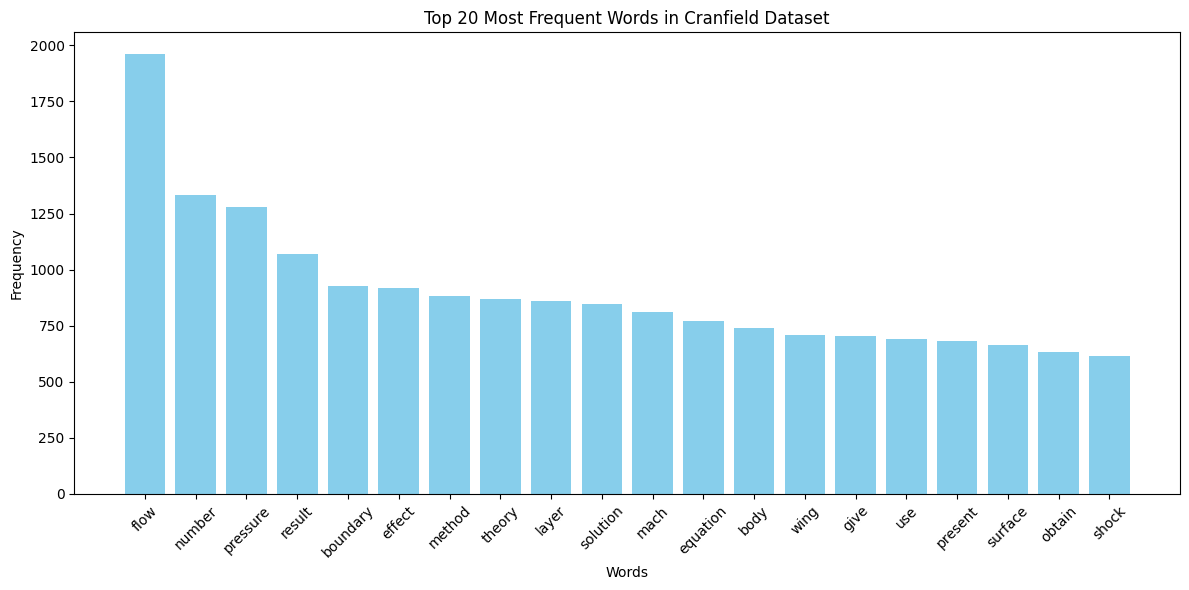

In [16]:
from collections import Counter
import matplotlib.pyplot as plt

# Document
all_text = ' '.join(df_docs['processed_text'])
word_counts = Counter(all_text.split())
common_words = word_counts.most_common(20)

words, counts = zip(*common_words)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.title('Top 20 Most Frequent Words in Cranfield Dataset')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

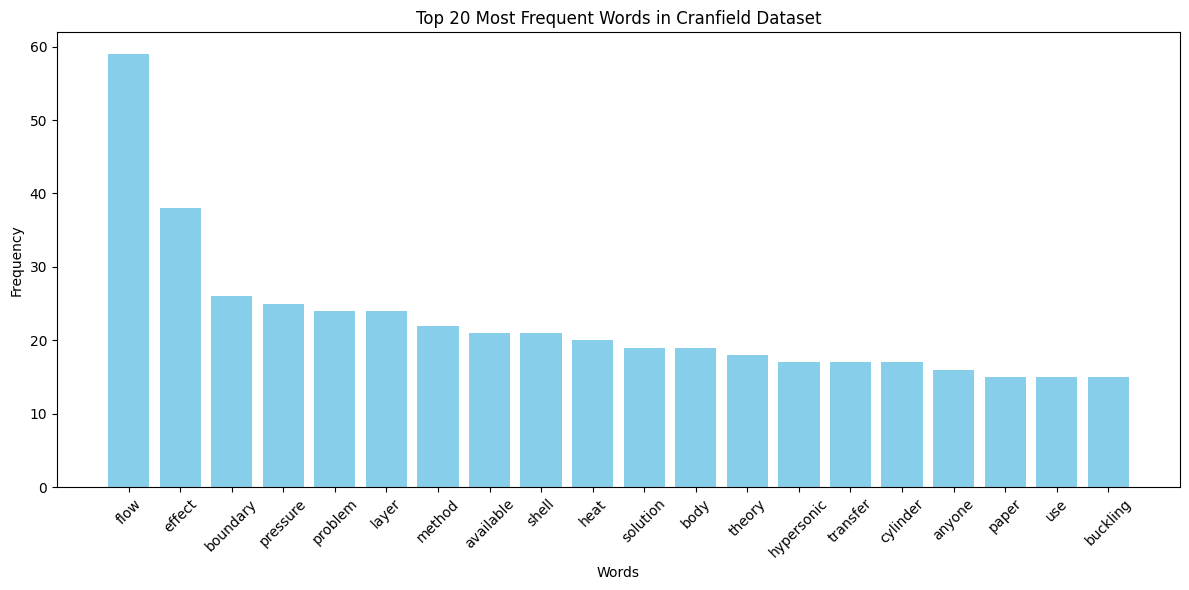

In [17]:
# Queries
all_text = ' '.join(df_queries['processed_text'])
word_counts = Counter(all_text.split())
common_words = word_counts.most_common(20)

words, counts = zip(*common_words)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.title('Top 20 Most Frequent Words in Cranfield Dataset')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Extracting and Inspecting Clean Vocabulary

In [18]:
# Documents
all_tokens = ' '.join(df_docs['processed_text']).split()
lowercase_tokens = [token.lower() for token in all_tokens]  # ← this ensures case consistency
sorted_vocab_docs = sorted(set(lowercase_tokens))


In [19]:
# Queries
all_tokens = ' '.join(df_queries['processed_text']).split()
lowercase_tokens = [token.lower() for token in all_tokens]  # ← this ensures case consistency
sorted_vocab_queries = sorted(set(lowercase_tokens))

# TF-IDF vectorization

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

## Document

In [21]:
corpus_docs = df_docs['processed_text'].tolist()
vectorizer = TfidfVectorizer(vocabulary=sorted_vocab_docs)
tfidf_matrix = vectorizer.fit_transform(corpus_docs)
tfidf_dense = tfidf_matrix.toarray()
terms = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_dense, columns=terms)

In [22]:
tfidf_df.sum().sort_values(ascending=False).head(100)

flow           65.657471
pressure       46.623546
number         46.133095
boundary       40.538671
layer          39.108577
                 ...    
thickness      14.789434
approximate    14.680499
stream         14.633236
lead           14.554041
stagnation     14.495301
Length: 100, dtype: float64

## Queries

In [23]:
corpus_queries = df_queries['processed_text'].tolist()

In [24]:
query_vec = vectorizer.transform(corpus_queries)  # returns sparse matrix

## Cosine Similarity

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

In [26]:
similarities = cosine_similarity(query_vec, tfidf_matrix)  
print(similarities[:20])

[[0.         0.02458718 0.         ... 0.         0.         0.        ]
 [0.01075268 0.04176568 0.         ... 0.01463784 0.         0.        ]
 [0.01014001 0.03938595 0.         ... 0.01380381 0.         0.        ]
 ...
 [0.08770745 0.02950274 0.03883139 ... 0.         0.         0.        ]
 [0.03760623 0.01997748 0.         ... 0.         0.         0.0050488 ]
 [0.04346375 0.0610006  0.02838707 ... 0.         0.         0.        ]]


## Rank the Documents by Similarity

In [27]:
# For One Query
top_k = 10
top_indices = np.argsort(similarities[0])[::-1][:top_k]

top_docs = df_docs.iloc[top_indices][['id', 'text']]  
top_scores = similarities[0][top_indices]

for i in range(top_k):
    print(f"Rank {i+1} | Doc ID: {top_docs.iloc[i]['id']} | Score: {top_scores[i]:.4f}")
    print(f"{top_docs.iloc[i]['text'][:300]}...\n")

Rank 1 | Doc ID: 51 | Score: 0.2570
theory of aircraft structural models subjected to aerodynamic
heating and external loads .
  the problem of investigating the simultaneous effects of transient
aerodynamic heating and external loads on aircraft structures for the
purpose of determining the ability of the structure to withstand fligh...

Rank 2 | Doc ID: 359 | Score: 0.2480
note on the hypersonic similarity law for an unyawed
cone .
  it is now known that the hypersonic similarity law derived for
slender cones and ogival bodies under the assumption, is
applicable for mach numbers as low as 3 .  this note makes use of
a series development to infer the hypersonic similar...

Rank 3 | Doc ID: 56 | Score: 0.1915
an analysis of the applicability of the hypersonic
similarity law to the study of the flow about bodies
of revolution at zero angle of attack .
  the hypersonic similarity law as derived by tsien has been
investigated by comparing the pressure distributions along bodies of
revolut

## Computing precision, Recall and MAP

In [28]:
ranked_docs_per_query = {}
doc_ids = df_docs['id'].tolist()

for q_idx, sim_scores in enumerate(similarities):
    ranked_indices = np.argsort(sim_scores)[::-1]  
    ranked_doc_ids = [doc_ids[i] for i in ranked_indices]
    query_id = df_queries.iloc[q_idx]['id']
    ranked_docs_per_query[query_id] = ranked_doc_ids


In [29]:
from sklearn.metrics import precision_score, recall_score

def calculate_metrics(qrels_df, ranked_docs_per_query, k=10):
    average_precisions = []

    for query_id, ranked_docs in ranked_docs_per_query.items():
        relevant_docs = qrels_df[qrels_df['query_id'] == query_id]['doc_id'].tolist()

        binary_relevance = [1 if doc_id in relevant_docs else 0 for doc_id in ranked_docs[:k]]

        retrieved_relevant = sum(binary_relevance)
        precision = retrieved_relevant / k
        recall = retrieved_relevant / len(relevant_docs) if relevant_docs else 0

        precisions = []
        for i, rel in enumerate(binary_relevance):
            if rel:
                precisions.append(sum(binary_relevance[:i+1]) / (i+1))
        ap = np.mean(precisions) if precisions else 0
        average_precisions.append(ap)

        print(f"Query ID: {query_id} | Precision@{k}: {precision:.3f} | Recall@{k}: {recall:.3f} | AP: {ap:.3f}")

    # Mean Average Precision (MAP)
    map_score = np.mean(average_precisions)
    print(f"\nMAP@{k}: {map_score:.4f}")


In [30]:
calculate_metrics(df_qrels, ranked_docs_per_query, k=10)

Query ID: 1 | Precision@10: 0.500 | Recall@10: 0.172 | AP: 0.768
Query ID: 2 | Precision@10: 0.400 | Recall@10: 0.160 | AP: 0.861
Query ID: 3 | Precision@10: 0.800 | Recall@10: 0.889 | AP: 0.986
Query ID: 4 | Precision@10: 0.300 | Recall@10: 1.000 | AP: 1.000
Query ID: 5 | Precision@10: 0.200 | Recall@10: 0.400 | AP: 0.325
Query ID: 6 | Precision@10: 0.200 | Recall@10: 0.400 | AP: 0.833
Query ID: 7 | Precision@10: 0.300 | Recall@10: 0.500 | AP: 0.722
Query ID: 8 | Precision@10: 0.300 | Recall@10: 0.250 | AP: 0.767
Query ID: 9 | Precision@10: 0.200 | Recall@10: 0.500 | AP: 1.000
Query ID: 10 | Precision@10: 0.300 | Recall@10: 0.333 | AP: 0.810
Query ID: 11 | Precision@10: 0.300 | Recall@10: 0.375 | AP: 0.722
Query ID: 12 | Precision@10: 0.200 | Recall@10: 0.333 | AP: 0.208
Query ID: 13 | Precision@10: 0.100 | Recall@10: 0.200 | AP: 1.000
Query ID: 14 | Precision@10: 0.200 | Recall@10: 0.667 | AP: 0.236
Query ID: 15 | Precision@10: 0.200 | Recall@10: 0.667 | AP: 0.625
Query ID: 16 | Prec

### MAP = 0.6524

# BM25-style normalization

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

In [32]:
corpus_docs = df_docs['processed_text'].tolist()
vectorizer = CountVectorizer(vocabulary=sorted_vocab_docs)
tf_matrix = vectorizer.fit_transform(corpus_docs).toarray()
terms = vectorizer.get_feature_names_out()
tf_df = pd.DataFrame(tf_matrix, columns=terms)

doc_lengths = tf_matrix.sum(axis=1)
avg_doc_length = np.mean(doc_lengths)

N = len(corpus_docs)
df_counts = np.sum(tf_matrix > 0, axis=0)
idf = np.log((N - df_counts + 0.5) / (df_counts + 0.5) + 1)

k1 = 2
b = 0.75

bm25_matrix = np.zeros_like(tf_matrix, dtype=float)

for i, doc_vec in enumerate(tf_matrix):
    doc_len = doc_lengths[i]
    for j, f_td in enumerate(doc_vec):
        if f_td == 0:
            continue
        denom = f_td + k1 * (1 - b + b * doc_len / avg_doc_length)
        score = idf[j] * (f_td * (k1 + 1)) / denom
        bm25_matrix[i, j] = score

bm25_df = pd.DataFrame(bm25_matrix, columns=terms)


In [33]:
corpus_queries = df_queries['processed_text'].tolist()
query_tf = vectorizer.transform(corpus_queries).toarray()

In [34]:
bm25_similarities = np.dot(query_tf, bm25_matrix.T)

## Rank the documents and calculate metrics

In [35]:
bm25_ranked_results = {}

for query_idx in range(bm25_similarities.shape[0]):
    scores = bm25_similarities[query_idx]
    ranked_doc_indices = scores.argsort()[::-1]
    ranked_doc_ids = df_docs.iloc[ranked_doc_indices]['id'].values.tolist()
    query_id = df_queries.iloc[query_idx]['id']
    bm25_ranked_results[query_id] = ranked_doc_ids


## Computing precision, Recall and MAP

In [36]:
def evaluate_bm25_ranking(qrels_df, bm25_ranked_results, k=10):
    average_precisions = []

    for query_id, ranked_docs in bm25_ranked_results.items():
        relevant_docs = qrels_df[qrels_df['query_id'] == query_id]['doc_id'].tolist()

        binary_relevance = [1 if doc_id in relevant_docs else 0 for doc_id in ranked_docs[:k]]

        retrieved_relevant = sum(binary_relevance)
        precision = retrieved_relevant / k
        recall = retrieved_relevant / len(relevant_docs) if relevant_docs else 0

        precisions = []
        for i, rel in enumerate(binary_relevance):
            if rel:
                precisions.append(sum(binary_relevance[:i+1]) / (i+1))
        ap = np.mean(precisions) if precisions else 0
        average_precisions.append(ap)

        print(f"Query ID: {query_id} | Precision@{k}: {precision:.3f} | Recall@{k}: {recall:.3f} | AP: {ap:.3f}")

    map_score = np.mean(average_precisions)
    print(f"\nBM25 MAP@{k}: {map_score:.4f}")


In [37]:
evaluate_bm25_ranking(df_qrels, bm25_ranked_results, k=10)

Query ID: 1 | Precision@10: 0.500 | Recall@10: 0.172 | AP: 0.775
Query ID: 2 | Precision@10: 0.300 | Recall@10: 0.120 | AP: 1.000
Query ID: 3 | Precision@10: 0.800 | Recall@10: 0.889 | AP: 0.975
Query ID: 4 | Precision@10: 0.300 | Recall@10: 1.000 | AP: 0.867
Query ID: 5 | Precision@10: 0.300 | Recall@10: 0.600 | AP: 0.411
Query ID: 6 | Precision@10: 0.200 | Recall@10: 0.400 | AP: 1.000
Query ID: 7 | Precision@10: 0.300 | Recall@10: 0.500 | AP: 1.000
Query ID: 8 | Precision@10: 0.200 | Recall@10: 0.167 | AP: 1.000
Query ID: 9 | Precision@10: 0.200 | Recall@10: 0.500 | AP: 0.500
Query ID: 10 | Precision@10: 0.400 | Recall@10: 0.444 | AP: 0.750
Query ID: 11 | Precision@10: 0.200 | Recall@10: 0.250 | AP: 0.833
Query ID: 12 | Precision@10: 0.300 | Recall@10: 0.500 | AP: 0.767
Query ID: 13 | Precision@10: 0.100 | Recall@10: 0.200 | AP: 1.000
Query ID: 14 | Precision@10: 0.100 | Recall@10: 0.333 | AP: 0.125
Query ID: 15 | Precision@10: 0.200 | Recall@10: 0.667 | AP: 1.000
Query ID: 16 | Prec

### MAP@10: 0.6944

# Log-Entropy Weighting

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

In [39]:
vectorizer = CountVectorizer(vocabulary=sorted_vocab_docs)
tf_matrix = vectorizer.fit_transform(corpus_docs)
tf_array = tf_matrix.toarray()

terms = vectorizer.get_feature_names_out()
tf_df = pd.DataFrame(tf_array, columns=terms)

local_weights = np.log1p(tf_array)

N = tf_array.shape[0]  
tf_term_sums = tf_array.sum(axis=0) + 1e-10  
tf_normalized = tf_array / tf_term_sums

entropy = -np.sum(tf_normalized * np.log(tf_normalized + 1e-10), axis=0) / np.log(N)
global_weights = 1 - entropy  

log_entropy_matrix = local_weights * global_weights
log_entropy_df = pd.DataFrame(log_entropy_matrix, columns=terms)


In [40]:
corpus_queries = df_queries['processed_text'].tolist()
query_tf_matrix = vectorizer.transform(corpus_queries)
query_tf_array = query_tf_matrix.toarray()
query_local_weights = np.log1p(query_tf_array)
query_log_entropy = query_local_weights * global_weights
query_log_entropy_df = pd.DataFrame(query_log_entropy, columns=terms)


In [41]:
from sklearn.metrics.pairwise import cosine_similarity
doc_matrix = log_entropy_df.values 
query_matrix = query_log_entropy    

similarities = cosine_similarity(query_matrix, doc_matrix)


## Rank the documents and calculate metrics

In [42]:
ranked_docs_per_query = {}
doc_ids = df_docs['id'].tolist()

for q_idx, sim_scores in enumerate(similarities):
    ranked_indices = np.argsort(sim_scores)[::-1]  
    ranked_doc_ids = [doc_ids[i] for i in ranked_indices]
    query_id = df_queries.iloc[q_idx]['id']
    ranked_docs_per_query[query_id] = ranked_doc_ids
calculate_metrics(df_qrels, ranked_docs_per_query, k=10)


Query ID: 1 | Precision@10: 0.500 | Recall@10: 0.172 | AP: 0.545
Query ID: 2 | Precision@10: 0.400 | Recall@10: 0.160 | AP: 0.787
Query ID: 3 | Precision@10: 0.800 | Recall@10: 0.889 | AP: 0.975
Query ID: 4 | Precision@10: 0.300 | Recall@10: 1.000 | AP: 0.867
Query ID: 5 | Precision@10: 0.300 | Recall@10: 0.600 | AP: 0.342
Query ID: 6 | Precision@10: 0.200 | Recall@10: 0.400 | AP: 0.700
Query ID: 7 | Precision@10: 0.300 | Recall@10: 0.500 | AP: 0.917
Query ID: 8 | Precision@10: 0.200 | Recall@10: 0.167 | AP: 0.310
Query ID: 9 | Precision@10: 0.200 | Recall@10: 0.500 | AP: 0.750
Query ID: 10 | Precision@10: 0.400 | Recall@10: 0.444 | AP: 0.768
Query ID: 11 | Precision@10: 0.200 | Recall@10: 0.250 | AP: 0.833
Query ID: 12 | Precision@10: 0.300 | Recall@10: 0.500 | AP: 0.500
Query ID: 13 | Precision@10: 0.100 | Recall@10: 0.200 | AP: 1.000
Query ID: 14 | Precision@10: 0.100 | Recall@10: 0.333 | AP: 0.111
Query ID: 15 | Precision@10: 0.200 | Recall@10: 0.667 | AP: 0.750
Query ID: 16 | Prec

### MAP@10: 0.6645

# Latent Semantic Analysis (LSA)

## Log-entropy

In [55]:
from sklearn.decomposition import TruncatedSVD

In [73]:
n_components = 800 

In [74]:
lsa = TruncatedSVD(n_components=n_components, random_state=42)
doc_lsa_matrix = lsa.fit_transform(log_entropy_df.values)

In [75]:
query_lsa_matrix = lsa.transform(query_log_entropy)

In [76]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(query_lsa_matrix, doc_lsa_matrix)


In [77]:
ranked_docs_per_query = {}
doc_ids = df_docs['id'].tolist()

for q_idx, sim_scores in enumerate(similarities):
    ranked_indices = np.argsort(sim_scores)[::-1]
    ranked_doc_ids = [doc_ids[i] for i in ranked_indices]
    query_id = df_queries.iloc[q_idx]['id']
    ranked_docs_per_query[query_id] = ranked_doc_ids

calculate_metrics(df_qrels, ranked_docs_per_query, k=10)


Query ID: 1 | Precision@10: 0.500 | Recall@10: 0.172 | AP: 0.559
Query ID: 2 | Precision@10: 0.300 | Recall@10: 0.120 | AP: 0.917
Query ID: 3 | Precision@10: 0.800 | Recall@10: 0.889 | AP: 1.000
Query ID: 4 | Precision@10: 0.300 | Recall@10: 1.000 | AP: 1.000
Query ID: 5 | Precision@10: 0.300 | Recall@10: 0.600 | AP: 0.389
Query ID: 6 | Precision@10: 0.200 | Recall@10: 0.400 | AP: 0.750
Query ID: 7 | Precision@10: 0.300 | Recall@10: 0.500 | AP: 1.000
Query ID: 8 | Precision@10: 0.300 | Recall@10: 0.250 | AP: 0.600
Query ID: 9 | Precision@10: 0.200 | Recall@10: 0.500 | AP: 1.000
Query ID: 10 | Precision@10: 0.500 | Recall@10: 0.556 | AP: 0.753
Query ID: 11 | Precision@10: 0.200 | Recall@10: 0.250 | AP: 1.000
Query ID: 12 | Precision@10: 0.300 | Recall@10: 0.500 | AP: 0.533
Query ID: 13 | Precision@10: 0.100 | Recall@10: 0.200 | AP: 1.000
Query ID: 14 | Precision@10: 0.100 | Recall@10: 0.333 | AP: 0.100
Query ID: 15 | Precision@10: 0.200 | Recall@10: 0.667 | AP: 0.833
Query ID: 16 | Prec

## TF-IDF

In [71]:
n_components = 800 

In [72]:
lsa = TruncatedSVD(n_components=n_components, random_state=42)
doc_lsa_matrix = lsa.fit_transform(tfidf_df.values)
query_lsa_matrix = lsa.transform(query_vec)

similarities = cosine_similarity(query_lsa_matrix, doc_lsa_matrix)
ranked_docs_per_query = {}
doc_ids = df_docs['id'].tolist()

for q_idx, sim_scores in enumerate(similarities):
    ranked_indices = np.argsort(sim_scores)[::-1]
    ranked_doc_ids = [doc_ids[i] for i in ranked_indices]
    query_id = df_queries.iloc[q_idx]['id']
    ranked_docs_per_query[query_id] = ranked_doc_ids

calculate_metrics(df_qrels, ranked_docs_per_query, k=10)


Query ID: 1 | Precision@10: 0.500 | Recall@10: 0.172 | AP: 0.686
Query ID: 2 | Precision@10: 0.300 | Recall@10: 0.120 | AP: 0.917
Query ID: 3 | Precision@10: 0.800 | Recall@10: 0.889 | AP: 0.986
Query ID: 4 | Precision@10: 0.300 | Recall@10: 1.000 | AP: 1.000
Query ID: 5 | Precision@10: 0.300 | Recall@10: 0.600 | AP: 0.342
Query ID: 6 | Precision@10: 0.200 | Recall@10: 0.400 | AP: 0.750
Query ID: 7 | Precision@10: 0.300 | Recall@10: 0.500 | AP: 0.643
Query ID: 8 | Precision@10: 0.400 | Recall@10: 0.333 | AP: 0.705
Query ID: 9 | Precision@10: 0.200 | Recall@10: 0.500 | AP: 1.000
Query ID: 10 | Precision@10: 0.300 | Recall@10: 0.333 | AP: 0.810
Query ID: 11 | Precision@10: 0.300 | Recall@10: 0.375 | AP: 0.833
Query ID: 12 | Precision@10: 0.300 | Recall@10: 0.500 | AP: 0.250
Query ID: 13 | Precision@10: 0.100 | Recall@10: 0.200 | AP: 1.000
Query ID: 14 | Precision@10: 0.200 | Recall@10: 0.667 | AP: 0.236
Query ID: 15 | Precision@10: 0.200 | Recall@10: 0.667 | AP: 0.625
Query ID: 16 | Prec

## BM25

In [67]:
n_components = 600

lsa = TruncatedSVD(n_components=n_components, random_state=42)
bm25_doc_lsa = lsa.fit_transform(bm25_df)


In [68]:
bm25_query_lsa = lsa.transform(query_tf)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but TruncatedSVD was fitted with feature names
  warnings.warn(


In [69]:
bm25_lsa_similarities = cosine_similarity(bm25_query_lsa, bm25_doc_lsa)

In [70]:
ranked_docs_per_query = {}
doc_ids = df_docs['id'].tolist()

for q_idx, sim_scores in enumerate(bm25_lsa_similarities):
    ranked_indices = np.argsort(sim_scores)[::-1]
    ranked_doc_ids = [doc_ids[i] for i in ranked_indices]
    query_id = df_queries.iloc[q_idx]['id']
    ranked_docs_per_query[query_id] = ranked_doc_ids

calculate_metrics(df_qrels, ranked_docs_per_query, k=10)


Query ID: 1 | Precision@10: 0.500 | Recall@10: 0.172 | AP: 0.711
Query ID: 2 | Precision@10: 0.300 | Recall@10: 0.120 | AP: 1.000
Query ID: 3 | Precision@10: 0.800 | Recall@10: 0.889 | AP: 0.986
Query ID: 4 | Precision@10: 0.300 | Recall@10: 1.000 | AP: 0.698
Query ID: 5 | Precision@10: 0.200 | Recall@10: 0.400 | AP: 0.417
Query ID: 6 | Precision@10: 0.200 | Recall@10: 0.400 | AP: 0.643
Query ID: 7 | Precision@10: 0.300 | Recall@10: 0.500 | AP: 0.867
Query ID: 8 | Precision@10: 0.300 | Recall@10: 0.250 | AP: 0.767
Query ID: 9 | Precision@10: 0.200 | Recall@10: 0.500 | AP: 0.625
Query ID: 10 | Precision@10: 0.500 | Recall@10: 0.556 | AP: 0.559
Query ID: 11 | Precision@10: 0.300 | Recall@10: 0.375 | AP: 0.810
Query ID: 12 | Precision@10: 0.300 | Recall@10: 0.500 | AP: 0.917
Query ID: 13 | Precision@10: 0.100 | Recall@10: 0.200 | AP: 1.000
Query ID: 14 | Precision@10: 0.000 | Recall@10: 0.000 | AP: 0.000
Query ID: 15 | Precision@10: 0.200 | Recall@10: 0.667 | AP: 0.833
Query ID: 16 | Prec